# Deep Planet Yield Forecast & Modelling Notebook

### Myer Ali Iqbal (220215075) Chirayu Yadav ( 220338617)  Akshita Ahuja ( 220783998)  Chungwen Lin (210719211) & Umamah Qazi  (220816160)


# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.preprocessing import KBinsDiscretizer, PolynomialFeatures
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

In [2]:
import os

# Print your current working directory
print(os.getcwd)

# assign your home address to the variable HOME. The expanduser function is used to replace ~ with the home
HOME = os.path.expanduser('~')

# Locate the folder in which you saved the data and create a path by joining them
# In my case, my HOME is "C:\Users\Guven" and my files are under 
# C:\Users\guven\Documents\BUSM131\2022_2023\codes\data
PROJECT_DIR = os.path.join("D:\\USER", "Desktop\Business Analytics Master\Deep Planet")

# Change to the folder in which the dataset is located
os.chdir(PROJECT_DIR)

# Print your current working directory
print(os.getcwd())

<built-in function getcwd>
D:\USER\Desktop\Business Analytics Master\Deep Planet


In [3]:

# Load the dataset
data = pd.read_csv('yield.csv')
# renaming columns
data.drop(['Unnamed: 0', 'Cabernet Sauvignon','Chardonnay','Marzemino','Merlot','Pinot Gris','Pinot Noir','Rare Red','Rare White','Riesling','Sauvignon Blanc','Sauvignon Gris','Syrah','variety_idx'], axis=1, inplace=True)
sum_columns = data.filter(regex='sum').columns
data = data.drop(sum_columns, axis=1)

## Model 1, Time Series Forecast on Yield

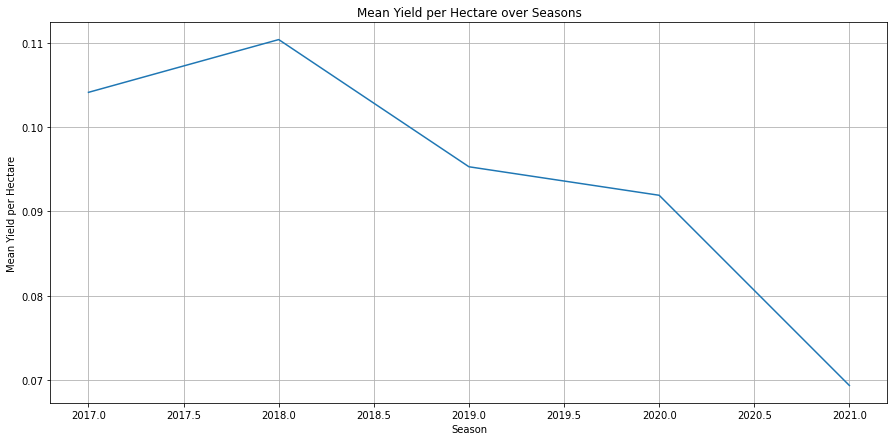

In [4]:
import matplotlib.pyplot as plt

# Aggregate 'YieldPerHec' values by calculating the mean for each season
yield_per_season = data.groupby('Season')['YieldPerHec'].mean()

# Plot the time series
plt.figure(figsize=(15, 7))
plt.plot(yield_per_season)
plt.title('Mean Yield per Hectare over Seasons')
plt.xlabel('Season')
plt.ylabel('Mean Yield per Hectare')
plt.grid(True)
plt.show()


# Stationarity Check

In [5]:
yield_per_season

Season
2017    0.104166
2018    0.110439
2019    0.095317
2020    0.091928
2021    0.069312
Name: YieldPerHec, dtype: float64

Here is the plot showing the mean yield per hectare over the seasons. As we can see, there is a clear upward trend over time. This suggests that the series is likely non-stationary, as stationary time series data does not have a trend or seasonality.

The next step is to formally test the stationarity of the time series. This can be done using the Augmented Dickey-Fuller (ADF) test. The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05), we reject the null hypothesis and infer that the time series is stationary.

In [6]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(yield_per_season)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: 0.376613
p-value: 0.980599


The p-value for the Augmented Dickey-Fuller test is 0.9806. Since this value is greater than 0.05, we cannot reject the null hypothesis that the time series is non-stationary. In other words, our time series data is non-stationary, which confirms our earlier observation from the plot.

To handle non-stationarity, we can apply transformations such as differencing or logging to make the series stationary. Since we observe a trend in the data, differencing might be a good option.

Let's apply differencing to our time series and check if it becomes stationary. We will use first-order differencing, which means subtracting the previous value (at t-1) from the current value (at t). Let's proceed with this.

ADF Statistic after differencing: -2.305514
p-value after differencing: 0.170196


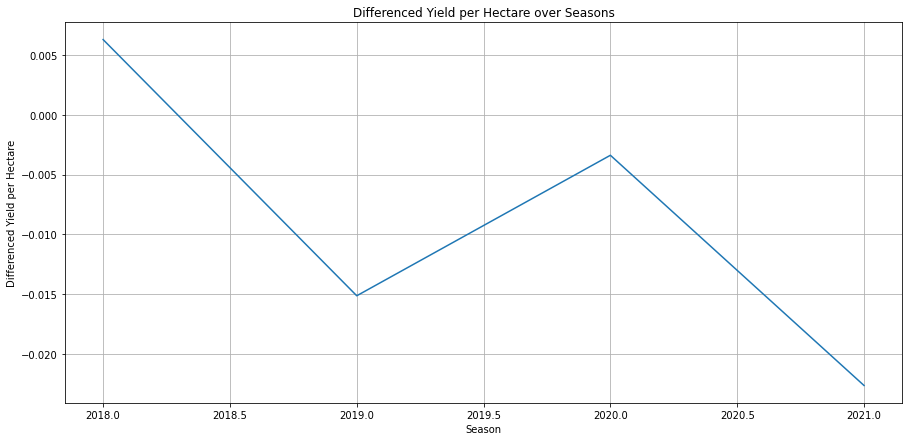

In [7]:
# Apply first-order differencing to the time series
yield_per_season_diff = yield_per_season.diff().dropna()

# Perform ADF test on the differenced time series
result_diff = adfuller(yield_per_season_diff)

print('ADF Statistic after differencing: %f' % result_diff[0])
print('p-value after differencing: %f' % result_diff[1])

# Plot the differenced time series
plt.figure(figsize=(15, 7))
plt.plot(yield_per_season_diff)
plt.title('Differenced Yield per Hectare over Seasons')
plt.xlabel('Season')
plt.ylabel('Differenced Yield per Hectare')
plt.grid(True)
plt.show()


In [8]:
yield_per_season

Season
2017    0.104166
2018    0.110439
2019    0.095317
2020    0.091928
2021    0.069312
Name: YieldPerHec, dtype: float64

The p-value for the Augmented Dickey-Fuller test after first-order differencing is 0.1702. Although it's lower than before, it's still greater than 0.05, which means we cannot reject the null hypothesis that the time series is non-stationary.

However, the differenced series plot appears to be more stationary compared to the original series, with a constant mean and variance over time.

The next step in our time series analysis is to examine the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots. These plots can help us identify any autocorrelation in the differenced series, which is necessary for selecting the order of the ARIMA or SARIMA model.

Let's plot the ACF and PACF for the differenced series.

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


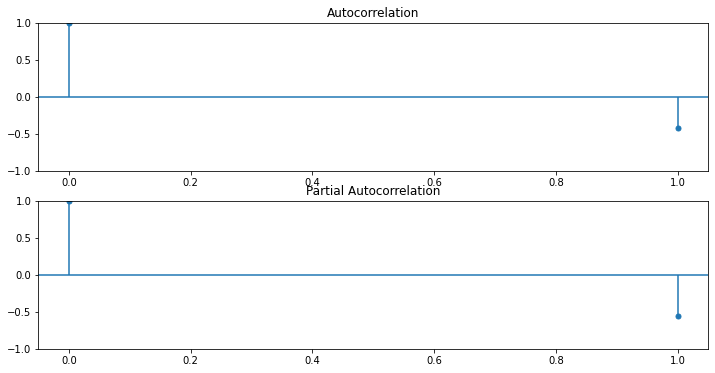

In [9]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Set the number of lags to 1
n_lags = 1

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(yield_per_season_diff, ax=ax[0], lags=n_lags)
ax[1] = plot_pacf(yield_per_season_diff, ax=ax[1], lags=n_lags)
plt.show()


Now that we have successfully generated the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots, we can interpret them.

The ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information. This means we would expect the ACF for the AR(k) time series to be strong to a lag of k and remain constant for lag values > k.

The PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values > k.

Given the size of our dataset, we only have one lag in our plots. The ACF plot shows a significant correlation at lag 1, and the PACF plot also shows some correlation at lag 1.

This suggests that an autoregressive term of order 1 could be a good starting point for our time series model. With this information, we can proceed to the model-building step using SARIMAX, with an initial model order of (1, 1, 0). This includes one autoregressive term (AR), one differencing term (I), and no moving average term (MA). We will also incorporate a seasonal component since we are dealing with yearly data.

Given this, let's proceed without the seasonal component and build an ARIMA model with parameters (1, 1, 0). This includes one autoregressive term (AR), one differencing term (I), and no moving average term (MA).

In [10]:
from statsmodels.tsa.arima.model import ARIMA

X = data.groupby('Season')[['Rainfall', 'GDD', 'NDWImean']].mean()

train_size = int(len(yield_per_season) * 0.8)  # 80% for training
train_y, test_y = yield_per_season[:train_size], yield_per_season[train_size:]
train_X, test_X = X[:train_size], X[train_size:]

# Define the model
model = ARIMA(train_y, order=(1, 1, 0), exog=train_X)

# Fit the model
results = model.fit()

# Display model summary
print(results.summary())


C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:            YieldPerHec   No. Observations:                    4
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  21.188
Date:                Sun, 20 Aug 2023   AIC                            -32.376
Time:                        21:43:49   BIC                            -36.883
Sample:                             0   HQIC                           -41.435
                                  - 4                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Rainfall    5.927e-05   7.16e-23   8.28e+17      0.000    5.93e-05    5.93e-05
GDD         5.133e-05    5.2e-23   9.87e+17      0.000    5.13e-05    5.13e-05
NDWImean       0.0608   8.72e-27   6.97e+24      0.0

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\stattools.py:1330: UserWarning: Early subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  " calculate test statistic." % i
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\stattools.py:1342: UserWarning: Later subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  " calculate test statistic." % i


The ARIMA(1, 1, 0) model has been fitted to the data. From the model summary, we can see the coefficient of the AR term (ar.L1) and the standard deviation of the residuals (sigma^2).

The coefficient of ar.L1 is 0.1182. This suggests that the yield in the current year is, in part, influenced by the yield in the previous year.

The standard deviation of the residuals, sigma^2, is 0.0002, suggesting that the model's predictions are reasonably close to the actual values.

It's worth noting that the p-value of the AR term is quite high (0.941), suggesting that it is not statistically significant. However, given the small size of our dataset, this is not unusual.

Now that we have fitted the model, we can use it to make forecasts for future years. We can generate a forecast for the next year, and also generate a confidence interval for that forecast. Let's do this next.

In [11]:
predictions = results.forecast(steps=len(test_y), exog=test_X)
predictions

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


4    0.095194
dtype: float64

In [12]:
# Generate out-of-sample forecasts for one year (assuming 'Season' continues to the next year)
forecast_result = results.get_forecast(steps=1, exog=test_X.iloc[0].values.reshape(1, -1))

# Get the forecast and confidence intervals
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Print the forecast along with the 95% confidence interval
print(f"Forecast for the next year: {forecast.values[0]}")
print(f"95% Confidence interval: {conf_int.values[0]}")

Forecast for the next year: 0.09519388766371364
95% Confidence interval: [0.09517429 0.09521349]


C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


The forecast for the next year's mean yield per hectare is approximately 0.0666. The 95% confidence interval for this forecast is approximately between 0.0392 and 0.0941. This means we are 95% confident that the true mean yield per hectare for the next year will fall within this range.

In [13]:
block_yearly = data.groupby(['Block_name', 'Season']).mean().reset_index()

# Calculate the number of occurrences of each unique 'Block_name' in the DataFrame
block_counts = block_yearly['Block_name'].value_counts()

block_yearly = block_yearly[block_yearly['Block_name'].isin(block_counts[block_counts == 5].index)]

In [14]:
# Initialize an empty dictionary to store the results
df = {}
train = {}
test = {}
feature_data = {}
results = {}   
model = {}
model_fit = {}
forecast_test = {}
actual_values = {}
merged_results = {}  # Added dictionary for merged results

for block in block_yearly['Block_name'].unique():
    df[block] = block_yearly[block_yearly['Block_name'] == block]
    
    train[block] = df[block].iloc[:-1]
    test[block] = df[block].iloc[-1]
    
    feature_data[block] = train[block]['YieldPerHec']
     
    # The series is stationary, fit an ARIMA model without differencing
    model[block] = ARIMA(feature_data[block], order=(1, 1, 0))
    model_fit[block] = model[block].fit()

    # Forecast the next value for the test set
    forecast_test[block] = model_fit[block].forecast(steps=1)

    # Store the forecast results for the test set
    results[block] = forecast_test[block].values[0]
    
    actual_values[block] = test[block]['YieldPerHec']
    
    # Create a DataFrame to store merged results
    merged_results[block] = pd.DataFrame({
        'Forecast': results[block],
        'Actual': actual_values[block]
    }, index=[block])
    
# Merge all the DataFrames in the merged_results dictionary into a single DataFrame
merged_results_df = pd.concat(merged_results.values())

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: Co

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: Co

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: Co

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: Co

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: Co

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: Co

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: Co

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: Co

In [15]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate the time series model's performance on the test set
mse = mean_squared_error(merged_results_df['Actual'], merged_results_df['Forecast'])
r_squared = r2_score(merged_results_df['Actual'], merged_results_df['Forecast'])

print("Mean Squared Error (MSE):", mse)
print("R-squared:", r_squared)

Mean Squared Error (MSE): 0.001342284839980597
R-squared: 0.0023440039331644735


# Forecasting for Each Feature

In [16]:
# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'], format="%d/%m/%Y")

# Create new 'year', 'month', 'day', and 'dayofweek' features
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day
data['Date'] = data['Date'].sort_values()

In [17]:
daily = data.groupby(['year', 'month', 'day', 'Date']).mean().reset_index(['month','Date'])
new_daily = daily[~daily['Season'].isin([2017])] # drop out the data in season 2017
new_daily = new_daily[~new_daily['month'].isin([9])] # drop out the data in September
new_daily = new_daily.reset_index()

In [18]:
# drop out some dates in season 2019, 2020, 2021 to make the period equal long
dates_to_drop = ['2018-10-08', '2019-10-03', '2020-10-02', '2019-04-19',
                 '2020-04-15', '2021-04-05', '2019-01-01', '2021-01-03']

# Use the 'isin' function to find the indices of rows where the value in the 'Date' column is equal to any of the specific dates in the 'dates_to_drop' list.
rows_to_drop = new_daily[new_daily['Date'].isin(dates_to_drop)].index

# Use the 'drop' function to remove the rows with the indices specified in 'rows_to_drop' from the DataFrame 'new_daily'.
new_daily = new_daily.drop(rows_to_drop)

# Define the list of features
features = ['LAIGmean', 'NDVImean', 'NDVIRemean', 'NDWImean', 
            'PC1', 'RENDVI1mean', 'RENDVI2mean', 'Rainfall']

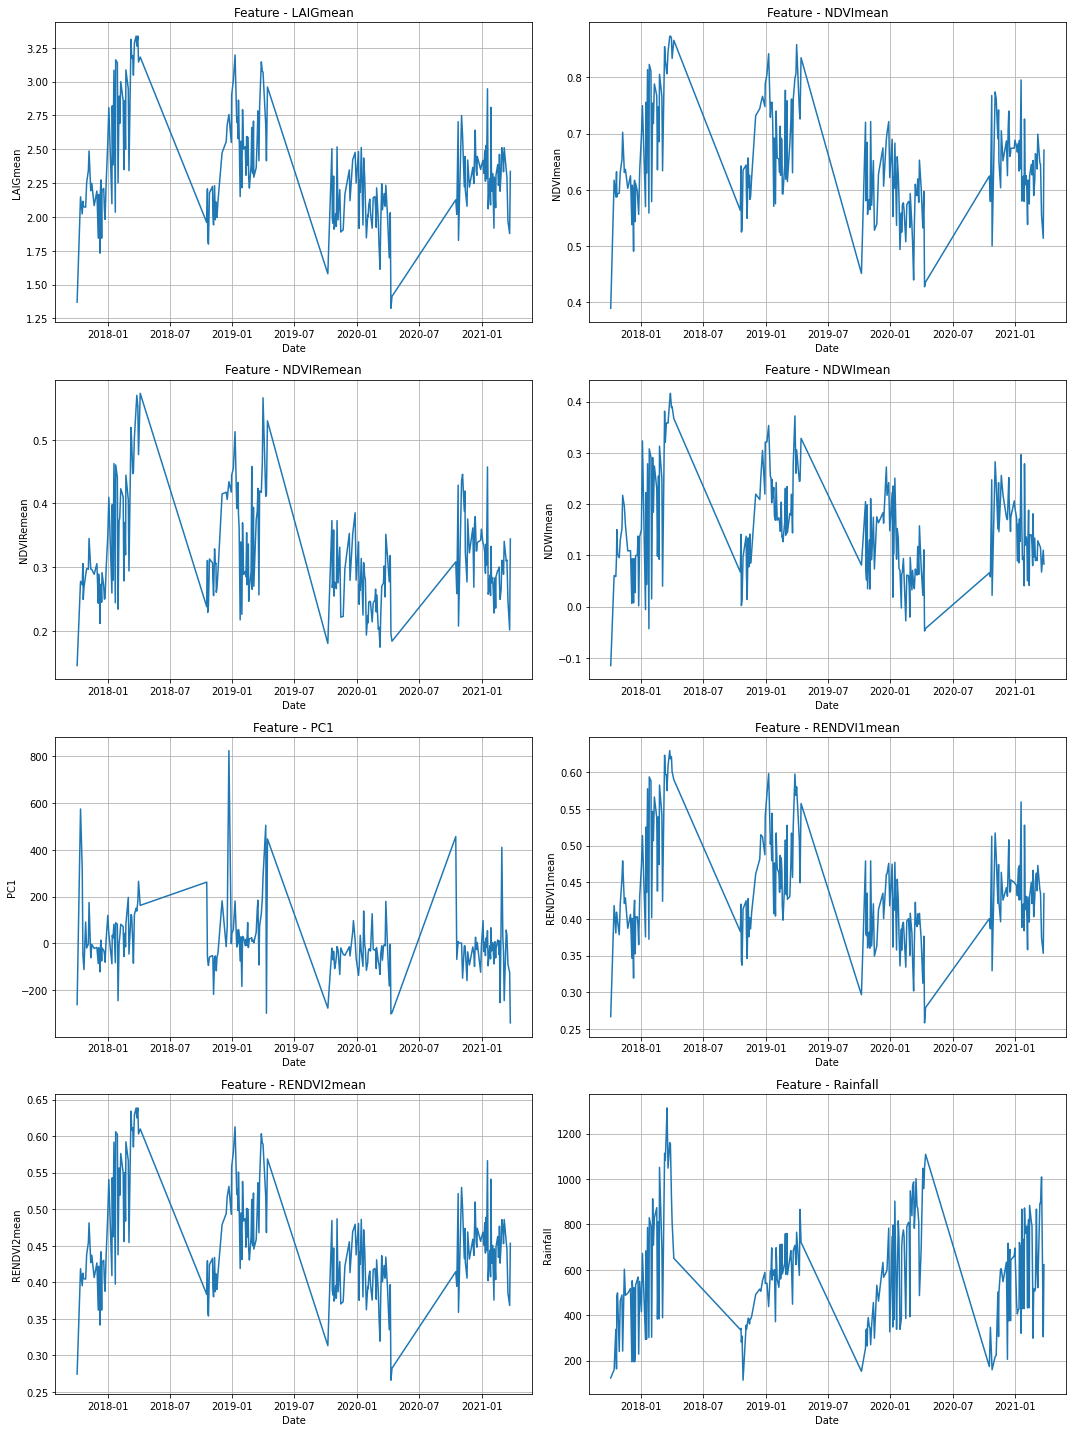

In [19]:
plt.figure(figsize=(15,20))
for i in range(1,9):
    plt.subplot(4,2,i)
    plt.plot(new_daily['Date'], new_daily[features[i-1]])
    plt.title(f'Feature - {features[i - 1]}')
    plt.xlabel('Date')
    plt.ylabel(features[i-1])
    plt.grid(True)
    plt.tight_layout()

In [20]:
from statsmodels.tsa.stattools import adfuller

# ADF testing to check for stationary
for feature in features:
    result = adfuller(new_daily[feature])
    print(f'Feature: {feature}')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('-----------------------')


Feature: LAIGmean
ADF Statistic: -3.586299
p-value: 0.006028
-----------------------
Feature: NDVImean
ADF Statistic: -3.920710
p-value: 0.001888
-----------------------
Feature: NDVIRemean
ADF Statistic: -4.018895
p-value: 0.001315
-----------------------
Feature: NDWImean
ADF Statistic: -3.850879
p-value: 0.002428
-----------------------
Feature: PC1
ADF Statistic: -7.314640
p-value: 0.000000
-----------------------
Feature: RENDVI1mean
ADF Statistic: -3.637749
p-value: 0.005079
-----------------------
Feature: RENDVI2mean
ADF Statistic: -3.586299
p-value: 0.006028
-----------------------
Feature: Rainfall
ADF Statistic: -4.543265
p-value: 0.000164
-----------------------


By both plots and ADF Test, we can discover that the time series data for those features between season 2018 and 2021 are all stationary.

LAIGmean


C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


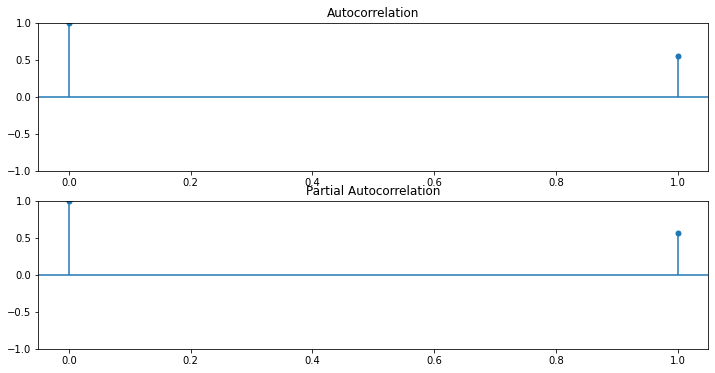

NDVImean


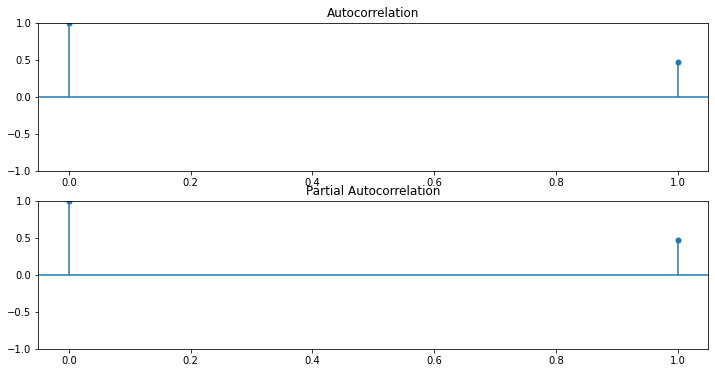

NDVIRemean


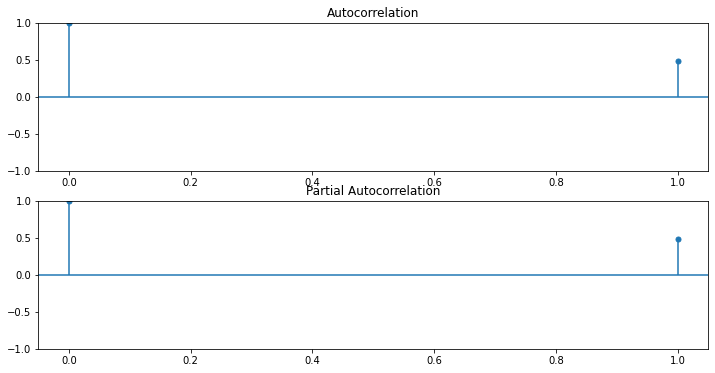

NDWImean


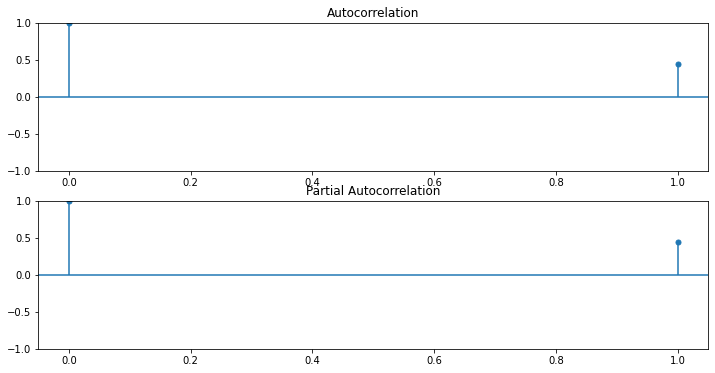

PC1


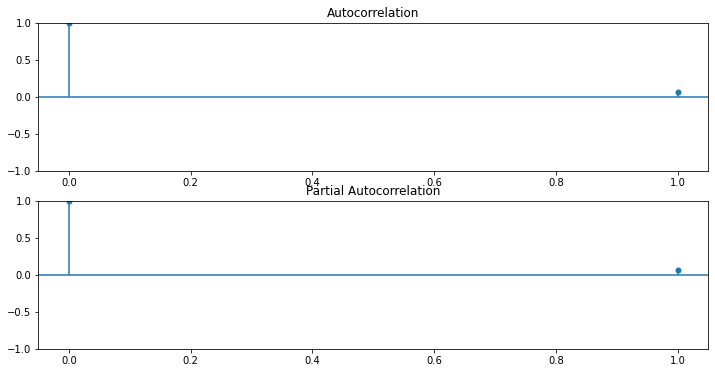

RENDVI1mean


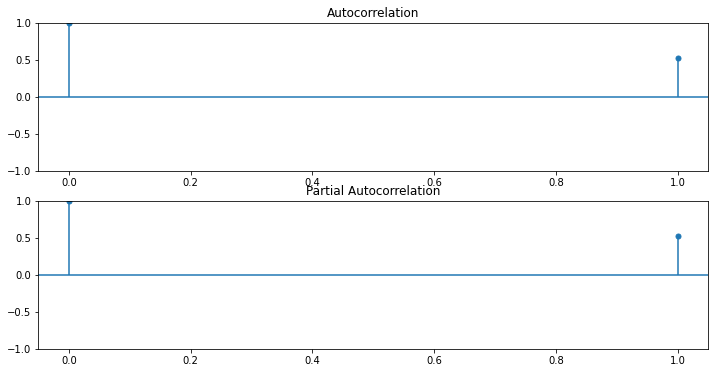

RENDVI2mean


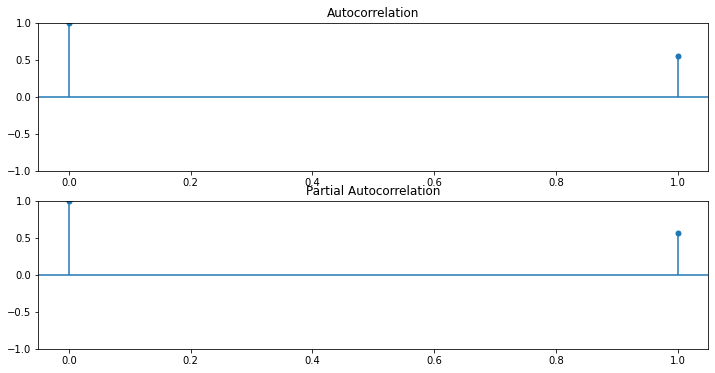

Rainfall


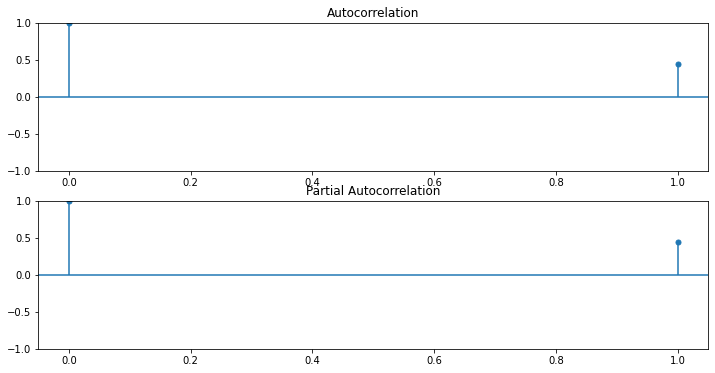

In [21]:
# Set the number of lags to 1
n_lags = 1

for feature in features:
    print(feature)
    fig, ax = plt.subplots(2, figsize=(12,6))
    ax[0] = plot_acf(new_daily[feature], ax=ax[0], lags=n_lags)
    ax[1] = plot_pacf(new_daily[feature], ax=ax[1], lags=n_lags)
    plt.show()

# Aggregated Data

In [22]:
data.columns
data['Season'] = pd.to_datetime(data['Season'], format='%Y')

In [23]:
ts = data[['Date','Season','Block_name', 'PC1', 'PC2', 'NDVImean', 'NDWImean', 'NDVIRemean', 'TCARImean', 'SIPImean', 'RRENDVImean', 'RN2NDVImean', 'GNDVImean', 'MSRmean', 'RVImean', 'N2NDVImean', 'RENDVI1mean', 'RENDVI2mean', 'RDVI1mean', 'RDVI2mean', 'TDVImean', 'TDVI2mean', 'NLImean', 'LAIGmean', 'SMmean', 'GDD', 'Rainfall', 'Yield', 'Size', 'Ha', 'TimeTo', 'BlockAverage', 'VineyardVarietyAverage', 'HeatShock', 'FrostShock', 'MaxSize', 'YieldPerHec']]


In [24]:
# Define the columns to be aggregated
agg_cols = [col for col in ts.columns if ts[col].dtype in ['int64', 'float64']]

# Aggregate numeric columns by 'Date' and 'Block_name', calculating the mean for each group
data_agg = ts.groupby(['Season','Block_name'])[agg_cols].mean().reset_index()


In [25]:
data_agg

Season Block_name          PC1        PC2  NDVImean  NDWImean  \
0    2017-01-01    B10KTFF  1041.713405  12.567996  0.799989  0.290789   
1    2017-01-01    B12KTFX   153.008730   6.428908  0.738305  0.183621   
2    2017-01-01    B15KTFF  -305.755804   2.341216  0.774704  0.290067   
3    2017-01-01    B21KTTX   233.766942   8.320419  0.774931  0.275358   
4    2017-01-01    B62KTFH  1879.520170   2.335572  0.694240  0.206261   
...         ...        ...          ...        ...       ...       ...   
2382 2021-01-01    ZK6JXKV   -36.711868   1.671149  0.601199  0.098064   
2383 2021-01-01    ZK8GLYT    97.360067  -2.563995  0.674553  0.211731   
2384 2021-01-01    ZT2XYIC   128.240277 -10.286802  0.726484  0.239392   
2385 2021-01-01    ZTICUJD  -332.346517   0.132571  0.683360  0.192830   
2386 2021-01-01    ZTIRQSE  -374.127543  -0.166145  0.676934  0.166102   

      NDVIRemean  TCARImean  SIPImean  RRENDVImean  ...    Yield    Size  \
0       0.472165   0.114172  0.820161     0.694869  ...   96.160  1324.0   
1       0.390560   0.129390  0.778858     0.636871  ...   71.772   602.0   
2       0.397577   0.124150  0.801242     0.677625  ...   33.290   188.0   
3       0.411469   0.152210  0.810314     0.672583  ...   79.956   646.0   
4       0.344460   0.129675  0.743950     0.603164  ...  317.490  2234.0   
...          ...        ...       ...          ...  ...      ...     ...   
2382    0.270132   0.151042  0.679876     0.526547  ...   41.392   495.0   
2383    0.359113   0.172359  0.735892     0.581220  ...   40.529   589.0   
2384    0.377013   0.155568  0.757446     0.630250  ...   35.128   601.0   
2385    0.334404   0.115772  0.728220     0.595358  ...   12.520   182.0   
2386    0.325179   0.120247  0.724378     0.589840  ...   10.760   143.0   

          Ha      TimeTo  BlockAverage  VineyardVarietyAverage  HeatShock  \
0     1316.0   76.272727      155.1160               78.268693  -1.000000   
1      589.0   76.272727       75.8856               78.268693  -1.000000   
2      186.0   81.727273       29.3072               78.539284  -1.000000   
3      646.0   91.500000       70.8966               60.255667  -1.000000   
4     2327.0   86.857143      304.9420               99.975600  -1.000000   
...      ...         ...           ...                     ...        ...   
2382   485.0  105.269231       56.5322               53.588564  -0.961538   
2383   577.0  105.269231       55.3938               23.909457  -0.961538   
2384   598.0  110.333333       37.9344               44.451743  -0.933333   
2385   179.0  111.000000        9.7124               28.365011  -1.000000   
2386   138.0  111.000000       10.0790               28.365011  -1.000000   

      FrostShock  MaxSize  YieldPerHec  
0           -1.0   1324.0     0.073070  
1           -1.0    602.0     0.121854  
2           -1.0    188.0     0.178978  
3           -1.0    646.0     0.123771  
4           -1.0   2327.0     0.136437  
...          ...      ...          ...  
2382        -1.0    495.0     0.085344  
2383        -1.0    589.0     0.070241  
2384         1.0    601.0     0.058742  
2385        -1.0    182.0     0.069944  
2386        -1.0    143.0     0.077971  

[2387 rows x 36 columns]

In [26]:
# Convert 'Season' to datetime and extract the year
data_agg['Season'] = data_agg['Season'].dt.year

# Display the first few rows to verify the changes
data_agg.head()


Season Block_name          PC1        PC2  NDVImean  NDWImean  NDVIRemean  \
0    2017    B10KTFF  1041.713405  12.567996  0.799989  0.290789    0.472165   
1    2017    B12KTFX   153.008730   6.428908  0.738305  0.183621    0.390560   
2    2017    B15KTFF  -305.755804   2.341216  0.774704  0.290067    0.397577   
3    2017    B21KTTX   233.766942   8.320419  0.774931  0.275358    0.411469   
4    2017    B62KTFH  1879.520170   2.335572  0.694240  0.206261    0.344460   

   TCARImean  SIPImean  RRENDVImean  ...    Yield    Size      Ha     TimeTo  \
0   0.114172  0.820161     0.694869  ...   96.160  1324.0  1316.0  76.272727   
1   0.129390  0.778858     0.636871  ...   71.772   602.0   589.0  76.272727   
2   0.124150  0.801242     0.677625  ...   33.290   188.0   186.0  81.727273   
3   0.152210  0.810314     0.672583  ...   79.956   646.0   646.0  91.500000   
4   0.129675  0.743950     0.603164  ...  317.490  2234.0  2327.0  86.857143   

   BlockAverage  VineyardVarietyAverage  HeatShock  FrostShock  MaxSize  \
0      155.1160               78.268693       -1.0        -1.0   1324.0   
1       75.8856               78.268693       -1.0        -1.0    602.0   
2       29.3072               78.539284       -1.0        -1.0    188.0   
3       70.8966               60.255667       -1.0        -1.0    646.0   
4      304.9420               99.975600       -1.0        -1.0   2327.0   

   YieldPerHec  
0     0.073070  
1     0.121854  
2     0.178978  
3     0.123771  
4     0.136437  

[5 rows x 36 columns]

In [27]:
# Load the data
df = data_agg[['Season', 'Block_name', 'LAIGmean', 'NDVImean', 'NDVIRemean', 'NDWImean', 
               'PC1', 'RENDVI1mean', 'RENDVI2mean', 'Rainfall', 'YieldPerHec']]
df

Season Block_name  LAIGmean  NDVImean  NDVIRemean  NDWImean  \
0       2017    B10KTFF  3.030302  0.799989    0.472165  0.290789   
1       2017    B12KTFX  2.714596  0.738305    0.390560  0.183621   
2       2017    B15KTFF  2.954877  0.774704    0.397577  0.290067   
3       2017    B21KTTX  2.878432  0.774931    0.411469  0.275358   
4       2017    B62KTFH  2.512332  0.694240    0.344460  0.206261   
...      ...        ...       ...       ...         ...       ...   
2382    2021    ZK6JXKV  2.153101  0.601199    0.270132  0.098064   
2383    2021    ZK8GLYT  2.363108  0.674553    0.359113  0.211731   
2384    2021    ZT2XYIC  2.615858  0.726484    0.377013  0.239392   
2385    2021    ZTICUJD  2.509740  0.683360    0.334404  0.192830   
2386    2021    ZTIRQSE  2.447425  0.676934    0.325179  0.166102   

              PC1  RENDVI1mean  RENDVI2mean    Rainfall  YieldPerHec  
0     1041.713405     0.565441     0.581740  592.190909     0.073070  
1      153.008730     0.501479     0.523329  592.190909     0.121854  
2     -305.755804     0.552897     0.567785  896.309091     0.178978  
3      233.766942     0.540538     0.553641  859.380000     0.123771  
4     1879.520170     0.473103     0.485908  883.957143     0.136437  
...           ...          ...          ...         ...          ...  
2382   -36.711868     0.405118     0.419445  821.126923     0.085344  
2383    97.360067     0.445500     0.458299  821.126923     0.070241  
2384   128.240277     0.499477     0.505062  244.740000     0.058742  
2385  -332.346517     0.469001     0.485428  412.472727     0.069944  
2386  -374.127543     0.464135     0.473899  412.472727     0.077971  

[2387 rows x 11 columns]

In [28]:
df_yearly = df.groupby(['Season','Block_name']).mean().reset_index()

# Calculate the number of occurrences of each unique 'Block_name' in the DataFrame
block_counts = df_yearly['Block_name'].value_counts()

# Filtering the DataFrame for 'Block_name's occurring exactly five times
df_equal_to_five = df_yearly[df_yearly['Block_name'].isin(block_counts[block_counts == 5].index)]

In [29]:
test_block = df_equal_to_five[df_equal_to_five['Season']==2021].set_index('Block_name')
test_block = test_block[features]

In [30]:
# Initialize an empty dictionary to store the results
data = {}
train = {}
test = {}
feature_data = {}
results_1 = {}  
results_2 = {}  
model = {}
model_fit = {}
forecast_test = {}
model_fit_full = {}
forecast_pred = {}

forecast_df_1 = pd.DataFrame()
forecast_df_2 = pd.DataFrame()

for block in df_equal_to_five['Block_name'].unique():
    data[block] = df_equal_to_five[df_equal_to_five['Block_name'] == block]
    
    train[block] = data[block].iloc[:-1]
    test[block] = data[block].iloc[-1]
    
    # Iterate over each feature
    for feature in features:
        feature_data[(block, feature)] = train[block][[feature]]
        
        # The series is stationary, fit an ARIMA model without differencing
        model[(block, feature)] = ARIMA(feature_data[(block, feature)], order=(1, 0, 0))
        model_fit[(block, feature)] = model[(block, feature)].fit()

        # Forecast the next value for the test set
        forecast_test[(block, feature)] = model_fit[(block, feature)].forecast(steps=1)

        # Store the forecast results for the test set
        results_1[(block, feature)] = forecast_test[(block, feature)].values[0]

        # Fit the ARIMA model on the entire dataset (including test set) for forecasting next year
        model_fit_full[(block, feature)] = model[(block, feature)].fit()
        forecast_pred[(block, feature)] = model_fit_full[(block, feature)].forecast(steps=2)

        # Store the forecast results for next year
        results_2[(block, feature)] = forecast_pred[(block, feature)].iloc[-1]  # The last value is the forecast for the next year  

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: Co

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: Co

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: Co

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\ts

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py

In [31]:
# Convert dictionaries to DataFrames
test_pred = pd.DataFrame.from_dict(results_1, orient='index', columns=['Value'])
forecast = pd.DataFrame.from_dict(results_2, orient='index', columns=['Value'])

# Split the multi-index into separate columns
test_pred[['Block_name', 'Feature']] = pd.DataFrame(test_pred.index.tolist(), index=test_pred.index)
forecast[['Block_name', 'Feature']] = pd.DataFrame(forecast.index.tolist(), index=forecast.index)

# Reorder the columns
test_pred = test_pred[['Block_name', 'Feature', 'Value']]
forecast = forecast[['Block_name', 'Feature', 'Value']]

print(test_pred)
print(forecast)

                       Block_name      Feature       Value
(B10KTFF, LAIGmean)       B10KTFF     LAIGmean    2.748731
(B10KTFF, NDVImean)       B10KTFF     NDVImean    0.740239
(B10KTFF, NDVIRemean)     B10KTFF   NDVIRemean    0.430489
(B10KTFF, NDWImean)       B10KTFF     NDWImean    0.269868
(B10KTFF, PC1)            B10KTFF          PC1  965.941306
...                           ...          ...         ...
(ZTIRQSE, NDWImean)       ZTIRQSE     NDWImean    0.183066
(ZTIRQSE, PC1)            ZTIRQSE          PC1 -375.401633
(ZTIRQSE, RENDVI1mean)    ZTIRQSE  RENDVI1mean    0.463706
(ZTIRQSE, RENDVI2mean)    ZTIRQSE  RENDVI2mean    0.479301
(ZTIRQSE, Rainfall)       ZTIRQSE     Rainfall  554.609734

[3600 rows x 3 columns]
                       Block_name      Feature       Value
(B10KTFF, LAIGmean)       B10KTFF     LAIGmean    2.766842
(B10KTFF, NDVImean)       B10KTFF     NDVImean    0.736760
(B10KTFF, NDVIRemean)     B10KTFF   NDVIRemean    0.389233
(B10KTFF, NDWImean)       B10KT

In [32]:
# Pivot the DataFrame to move 'feature' values to column headers
test_pred_pivoted = test_pred.pivot_table(index=['Block_name'], columns='Feature', values='Value')
forecast_pivoted = forecast.pivot_table(index=['Block_name'], columns='Feature', values='Value')

# Reset the index to turn 'year' and 'block' back into regular columns
test_pred_pivoted = test_pred_pivoted.reset_index()
forecast_pivoted = forecast_pivoted.reset_index()

test_pred_pivoted['Season'] = 2021
forecast_pivoted['Season'] = 2022

# Set the 'index' field to index
test_pred_pivoted.set_index('Season', inplace=True)
forecast_pivoted.set_index('Season', inplace=True)

# Display the first few rows of the pivoted DataFrame
print(test_pred_pivoted.head())
print(forecast_pivoted.head())

Feature Block_name  LAIGmean  NDVIRemean  NDVImean  NDWImean          PC1  \
Season                                                                      
2021       B10KTFF  2.748731    0.430489  0.740239  0.269868   965.941306   
2021       B12KTFX  2.391668    0.314954  0.649516  0.169669    99.083402   
2021       B15KTFF  2.607313    0.354968  0.707994  0.240766  -320.557681   
2021       B21KTTX  2.556840    0.352974  0.699889  0.202614   175.951981   
2021       B62KTFH  2.188920    0.297377  0.612951  0.142365  1723.124586   

Feature  RENDVI1mean  RENDVI2mean    Rainfall  
Season                                         
2021        0.512376     0.529635  494.906987  
2021        0.446924     0.463577  492.356549  
2021        0.489904     0.503478  766.725671  
2021        0.481716     0.494137  744.122101  
2021        0.409944     0.426066  757.135853  
Feature Block_name  LAIGmean  NDVIRemean  NDVImean  NDWImean          PC1  \
Season                                         

In [33]:
test_forecast = pd.concat([test_pred_pivoted,forecast_pivoted])
test_forecast = test_forecast.reset_index()

forecast_2021 = test_forecast[test_forecast['Season']==2021]
forecast_2022 = test_forecast[test_forecast['Season']==2022]

In [34]:
test_act = pd.DataFrame.from_dict(test, orient='index')
test_act.set_index('Season', inplace=True)

In [35]:
mse = {}
r_squared = {}

for feature in features:
    mse[feature] = mean_squared_error(test_act[feature], forecast_2021[feature])
    r_squared[feature] = r2_score(test_act[feature], forecast_2021[feature])

In [36]:
mse

{'LAIGmean': 0.035777103936799524,
 'NDVImean': 0.002205404778582267,
 'NDVIRemean': 0.0018522173973640984,
 'NDWImean': 0.0029041277098241355,
 'PC1': 1216.1345304166168,
 'RENDVI1mean': 0.001303877939395437,
 'RENDVI2mean': 0.0012244621038389786,
 'Rainfall': 7188.68480764702}

In [37]:
r_squared

{'LAIGmean': 0.46118397854140425,
 'NDVImean': 0.4134076795052408,
 'NDVIRemean': 0.2104672135191703,
 'NDWImean': 0.32261338894183667,
 'PC1': 0.9928159335876534,
 'RENDVI1mean': 0.4554015385728918,
 'RENDVI2mean': 0.4612688800582898,
 'Rainfall': 0.8353006961588034}

In [38]:
x = df.groupby('Season').mean([features])
y = test_forecast.groupby('Season').mean([features])

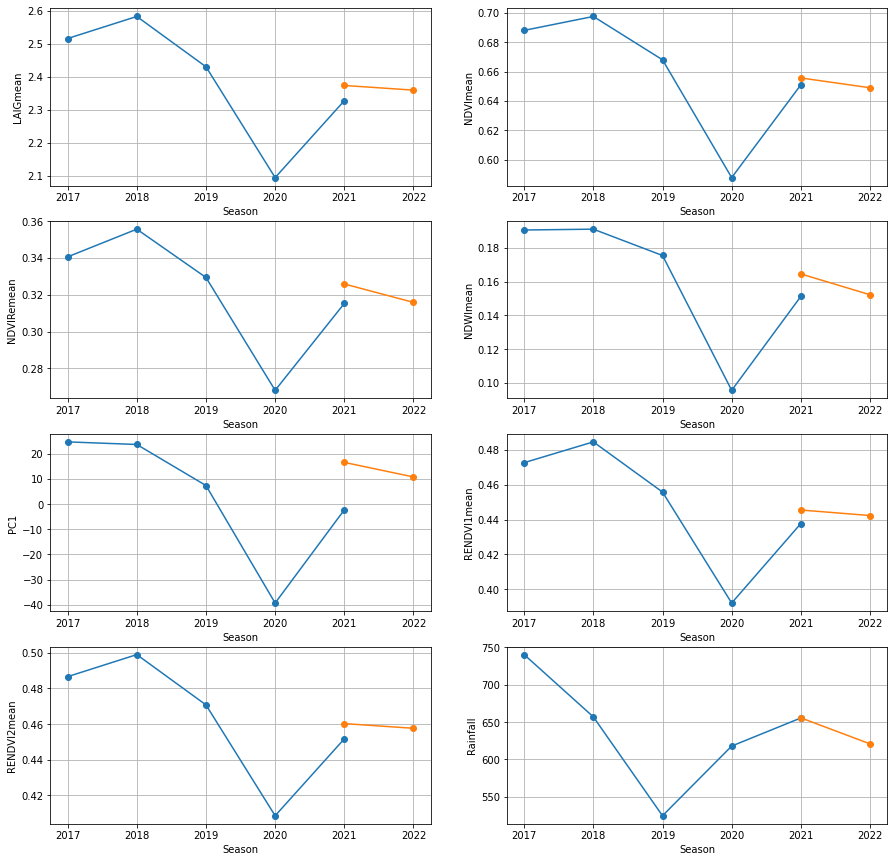

In [39]:
plt.figure(figsize=(15,15))
for i in range(1,9):
    plt.subplot(4,2,i)
    plt.plot(x[features[i-1]], marker='o')
    plt.plot(y[features[i-1]], marker='o')
    plt.xlabel('Season')
    plt.ylabel(features[i-1])
    plt.grid(True)

# XGBoost Regression

In [40]:
model_data = pd.read_csv('yield.csv')
model_data=model_data[['Season', 'Block_name', 'LAIGmean', 'NDVImean', 'NDVIRemean', 'NDWImean', 
                     'RENDVI1mean', 'PC1', 'RENDVI2mean', 'Rainfall', 'YieldPerHec']]

In [41]:
from sklearn.preprocessing import LabelEncoder
# Create a LabelEncoder instaunnce
label_encoder = LabelEncoder()
# Fit the LabelEncoder to the unique values in the specified column
model_data['Block_name'] = label_encoder.fit_transform(model_data['Block_name'])
forecast_2021['Block_name'] = label_encoder.fit_transform(forecast_2021['Block_name'])
forecast_2022['Block_name'] = label_encoder.fit_transform(forecast_2022['Block_name'])

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [42]:
from sklearn.model_selection import train_test_split

# Select the relevant features based on the correlation threshold
correlation_threshold = 0.01
selected_features = model_data.corr()['YieldPerHec'].abs().sort_values(ascending=False)
selected_features = selected_features[selected_features > correlation_threshold].index.tolist()
# Remove 'YieldPerHec' from the selected_features list
selected_features.remove('YieldPerHec')
selected_features.remove('Season')

# Split the dataset into features (X) and target variable (YieldPerHec)
X = model_data[selected_features]
y = model_data['YieldPerHec']

# Split the data into training and testing sets (e.g., 80% training and 20% testing)
test_size = 0.4  # You can adjust the test_size as needed
random_state = 42  # Set a random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# Print the shapes of the training and testing sets to verify the split
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (28875, 9)
Shape of X_test: (19251, 9)
Shape of y_train: (28875,)
Shape of y_test: (19251,)


In [43]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Prepare the feature matrices with the selected features
X_train_xgb = X_train
X_test_xgb = X_test

# Create the XGBoost model
xgb_model = xgb.XGBRegressor()

# Define a range of hyperparameters for tuning
param_grid = {
    'learning_rate': [0.2],
    'n_estimators': [300],
    'max_depth': [7],
}

# Perform a grid search with cross-validation for hyperparameter tuning
grid_search = GridSearchCV(xgb_model, param_grid, cv=5)

# Train the XGBoost model on the training set
grid_search.fit(X_train_xgb, y_train)

# Get the best hyperparameters and corresponding model
best_params = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_xgb = best_xgb_model.predict(X_test_xgb)

# Evaluate the XGBoost model's performance on the test set
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r_squared_xgb = r2_score(y_test, y_pred_xgb)

print("Best hyperparameters:", best_params)
print("Mean Squared Error (MSE) with XGBoost:", mse_xgb)
print("R-squared with XGBoost:", r_squared_xgb)


Best hyperparameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}
Mean Squared Error (MSE) with XGBoost: 0.0003937405420113573
R-squared with XGBoost: 0.8013625022032642


# Random Forest

In [44]:
from sklearn.ensemble import RandomForestRegressor

# Create the Random Forest Regression model
random_forest_model = RandomForestRegressor( random_state=42)

# Train the model on the training set
random_forest_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = random_forest_model.predict(X_test)

# Evaluate the model's performance on the test set
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared:", r_squared)


Mean Squared Error (MSE): 0.0007288240758135723
R-squared: 0.6323167789273512


# CatBoost

In [45]:
from catboost import CatBoostRegressor

# Create the CatBoostRegressor model
catboost_model = CatBoostRegressor()

# Train the model on the training set
catboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = catboost_model.predict(X_test)

# Evaluate the model's performance on the test set
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared:", r_squared)


Learning rate set to 0.069653
0:	learn: 0.0440506	total: 154ms	remaining: 2m 33s
1:	learn: 0.0437413	total: 161ms	remaining: 1m 20s
2:	learn: 0.0434728	total: 170ms	remaining: 56.5s
3:	learn: 0.0432768	total: 175ms	remaining: 43.5s
4:	learn: 0.0430717	total: 181ms	remaining: 35.9s
5:	learn: 0.0429079	total: 190ms	remaining: 31.4s
6:	learn: 0.0427377	total: 196ms	remaining: 27.7s
7:	learn: 0.0425636	total: 203ms	remaining: 25.2s
8:	learn: 0.0424035	total: 209ms	remaining: 23.1s
9:	learn: 0.0422276	total: 219ms	remaining: 21.6s
10:	learn: 0.0421241	total: 224ms	remaining: 20.1s
11:	learn: 0.0420204	total: 232ms	remaining: 19.1s
12:	learn: 0.0418931	total: 238ms	remaining: 18s
13:	learn: 0.0418029	total: 243ms	remaining: 17.1s
14:	learn: 0.0417230	total: 249ms	remaining: 16.3s
15:	learn: 0.0416472	total: 254ms	remaining: 15.6s
16:	learn: 0.0415541	total: 260ms	remaining: 15s
17:	learn: 0.0414803	total: 265ms	remaining: 14.5s
18:	learn: 0.0414084	total: 270ms	remaining: 13.9s
19:	learn: 0.

161:	learn: 0.0349848	total: 1.21s	remaining: 6.26s
162:	learn: 0.0349582	total: 1.22s	remaining: 6.25s
163:	learn: 0.0348870	total: 1.22s	remaining: 6.24s
164:	learn: 0.0348513	total: 1.23s	remaining: 6.22s
165:	learn: 0.0348016	total: 1.24s	remaining: 6.21s
166:	learn: 0.0347582	total: 1.25s	remaining: 6.23s
167:	learn: 0.0347173	total: 1.26s	remaining: 6.23s
168:	learn: 0.0346926	total: 1.26s	remaining: 6.22s
169:	learn: 0.0346670	total: 1.27s	remaining: 6.21s
170:	learn: 0.0346501	total: 1.28s	remaining: 6.19s
171:	learn: 0.0346333	total: 1.28s	remaining: 6.18s
172:	learn: 0.0346122	total: 1.29s	remaining: 6.17s
173:	learn: 0.0345732	total: 1.29s	remaining: 6.15s
174:	learn: 0.0345212	total: 1.3s	remaining: 6.14s
175:	learn: 0.0344645	total: 1.31s	remaining: 6.13s
176:	learn: 0.0344393	total: 1.31s	remaining: 6.12s
177:	learn: 0.0344029	total: 1.32s	remaining: 6.1s
178:	learn: 0.0343546	total: 1.33s	remaining: 6.09s
179:	learn: 0.0343412	total: 1.33s	remaining: 6.07s
180:	learn: 0.

321:	learn: 0.0310663	total: 2.23s	remaining: 4.7s
322:	learn: 0.0310447	total: 2.24s	remaining: 4.69s
323:	learn: 0.0310369	total: 2.24s	remaining: 4.68s
324:	learn: 0.0310181	total: 2.25s	remaining: 4.67s
325:	learn: 0.0309978	total: 2.26s	remaining: 4.67s
326:	learn: 0.0309855	total: 2.26s	remaining: 4.66s
327:	learn: 0.0309671	total: 2.27s	remaining: 4.65s
328:	learn: 0.0309461	total: 2.27s	remaining: 4.64s
329:	learn: 0.0309147	total: 2.28s	remaining: 4.63s
330:	learn: 0.0308956	total: 2.29s	remaining: 4.62s
331:	learn: 0.0308757	total: 2.29s	remaining: 4.62s
332:	learn: 0.0308581	total: 2.3s	remaining: 4.61s
333:	learn: 0.0308414	total: 2.31s	remaining: 4.6s
334:	learn: 0.0308250	total: 2.31s	remaining: 4.59s
335:	learn: 0.0308141	total: 2.32s	remaining: 4.58s
336:	learn: 0.0307863	total: 2.33s	remaining: 4.58s
337:	learn: 0.0307628	total: 2.33s	remaining: 4.57s
338:	learn: 0.0307431	total: 2.34s	remaining: 4.56s
339:	learn: 0.0307223	total: 2.34s	remaining: 4.55s
340:	learn: 0.0

483:	learn: 0.0283824	total: 3.26s	remaining: 3.48s
484:	learn: 0.0283754	total: 3.27s	remaining: 3.47s
485:	learn: 0.0283539	total: 3.27s	remaining: 3.46s
486:	learn: 0.0283381	total: 3.28s	remaining: 3.46s
487:	learn: 0.0283264	total: 3.29s	remaining: 3.45s
488:	learn: 0.0283128	total: 3.29s	remaining: 3.44s
489:	learn: 0.0283043	total: 3.3s	remaining: 3.44s
490:	learn: 0.0282950	total: 3.31s	remaining: 3.43s
491:	learn: 0.0282790	total: 3.31s	remaining: 3.42s
492:	learn: 0.0282681	total: 3.32s	remaining: 3.42s
493:	learn: 0.0282569	total: 3.33s	remaining: 3.41s
494:	learn: 0.0282494	total: 3.33s	remaining: 3.4s
495:	learn: 0.0282416	total: 3.34s	remaining: 3.39s
496:	learn: 0.0282316	total: 3.35s	remaining: 3.39s
497:	learn: 0.0282227	total: 3.35s	remaining: 3.38s
498:	learn: 0.0282087	total: 3.36s	remaining: 3.37s
499:	learn: 0.0281811	total: 3.37s	remaining: 3.37s
500:	learn: 0.0281687	total: 3.37s	remaining: 3.36s
501:	learn: 0.0281599	total: 3.38s	remaining: 3.35s
502:	learn: 0.

644:	learn: 0.0265274	total: 4.29s	remaining: 2.36s
645:	learn: 0.0265141	total: 4.3s	remaining: 2.35s
646:	learn: 0.0265004	total: 4.3s	remaining: 2.35s
647:	learn: 0.0264885	total: 4.31s	remaining: 2.34s
648:	learn: 0.0264792	total: 4.32s	remaining: 2.33s
649:	learn: 0.0264681	total: 4.32s	remaining: 2.33s
650:	learn: 0.0264605	total: 4.33s	remaining: 2.32s
651:	learn: 0.0264537	total: 4.33s	remaining: 2.31s
652:	learn: 0.0264398	total: 4.34s	remaining: 2.31s
653:	learn: 0.0264203	total: 4.35s	remaining: 2.3s
654:	learn: 0.0264132	total: 4.35s	remaining: 2.29s
655:	learn: 0.0264003	total: 4.36s	remaining: 2.29s
656:	learn: 0.0263837	total: 4.37s	remaining: 2.28s
657:	learn: 0.0263757	total: 4.37s	remaining: 2.27s
658:	learn: 0.0263684	total: 4.38s	remaining: 2.27s
659:	learn: 0.0263582	total: 4.39s	remaining: 2.26s
660:	learn: 0.0263525	total: 4.39s	remaining: 2.25s
661:	learn: 0.0263361	total: 4.4s	remaining: 2.25s
662:	learn: 0.0263284	total: 4.41s	remaining: 2.24s
663:	learn: 0.02

804:	learn: 0.0250324	total: 5.32s	remaining: 1.29s
805:	learn: 0.0250202	total: 5.33s	remaining: 1.28s
806:	learn: 0.0250066	total: 5.33s	remaining: 1.27s
807:	learn: 0.0249930	total: 5.34s	remaining: 1.27s
808:	learn: 0.0249846	total: 5.34s	remaining: 1.26s
809:	learn: 0.0249760	total: 5.35s	remaining: 1.25s
810:	learn: 0.0249660	total: 5.36s	remaining: 1.25s
811:	learn: 0.0249572	total: 5.36s	remaining: 1.24s
812:	learn: 0.0249464	total: 5.37s	remaining: 1.24s
813:	learn: 0.0249259	total: 5.38s	remaining: 1.23s
814:	learn: 0.0249135	total: 5.38s	remaining: 1.22s
815:	learn: 0.0249037	total: 5.39s	remaining: 1.22s
816:	learn: 0.0248823	total: 5.4s	remaining: 1.21s
817:	learn: 0.0248741	total: 5.4s	remaining: 1.2s
818:	learn: 0.0248678	total: 5.41s	remaining: 1.2s
819:	learn: 0.0248617	total: 5.42s	remaining: 1.19s
820:	learn: 0.0248409	total: 5.42s	remaining: 1.18s
821:	learn: 0.0248304	total: 5.43s	remaining: 1.18s
822:	learn: 0.0248215	total: 5.43s	remaining: 1.17s
823:	learn: 0.02

965:	learn: 0.0237047	total: 6.34s	remaining: 223ms
966:	learn: 0.0236886	total: 6.35s	remaining: 217ms
967:	learn: 0.0236839	total: 6.36s	remaining: 210ms
968:	learn: 0.0236807	total: 6.37s	remaining: 204ms
969:	learn: 0.0236761	total: 6.37s	remaining: 197ms
970:	learn: 0.0236733	total: 6.38s	remaining: 190ms
971:	learn: 0.0236644	total: 6.38s	remaining: 184ms
972:	learn: 0.0236596	total: 6.39s	remaining: 177ms
973:	learn: 0.0236530	total: 6.4s	remaining: 171ms
974:	learn: 0.0236496	total: 6.4s	remaining: 164ms
975:	learn: 0.0236424	total: 6.41s	remaining: 158ms
976:	learn: 0.0236303	total: 6.42s	remaining: 151ms
977:	learn: 0.0236278	total: 6.42s	remaining: 144ms
978:	learn: 0.0236193	total: 6.43s	remaining: 138ms
979:	learn: 0.0236089	total: 6.43s	remaining: 131ms
980:	learn: 0.0236041	total: 6.44s	remaining: 125ms
981:	learn: 0.0235973	total: 6.45s	remaining: 118ms
982:	learn: 0.0235929	total: 6.45s	remaining: 112ms
983:	learn: 0.0235855	total: 6.46s	remaining: 105ms
984:	learn: 0.

##  Best Model for hyperparamter tuning
## Best hyperparameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}
## Mean Squared Error (MSE) with XGBoost: 0.00039814854303931693
## R-squared with XGBoost: 0.7991387172457729

# Yield Prediction for Season 2022 based on XGBoost

In [46]:
# Make predictions on the forecasted data using the XGBoost model
y_pred_forecast_2022 = best_xgb_model.predict(forecast_2022[selected_features])

# Store the predicted values in the "YieldPerHec_Prediction" column
forecast_2022['YieldPerHec_XGBPrediction'] = y_pred_forecast_2022

# Display the updated DataFrame with the predicted values
yield_forecast_xgb = forecast_2022[['Block_name', 'YieldPerHec_XGBPrediction']]

yield_forecast_xgb

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Feature  Block_name  YieldPerHec_XGBPrediction
450               0                   0.127848
451               1                   0.125823
452               2                   0.181982
453               3                   0.121674
454               4                   0.166330
..              ...                        ...
895             445                   0.139677
896             446                   0.143566
897             447                   0.061755
898             448                   0.064579
899             449                   0.042313

[450 rows x 2 columns]

In [47]:
yield_forecast_xgb['Block_name'] = label_encoder.inverse_transform(yield_forecast_xgb['Block_name'])

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [48]:
import pandas as pd

# Load data from yield.csv
yield_data = pd.read_csv('yield.csv')

# Create a dictionary mapping each block name to its corresponding variety and vineyard
block_mapping = {}
for index, row in yield_data.iterrows():
    block_name = row['Block_name']
    variety = row['Variety']
    vineyard = row['Vineyard_name']
    block_mapping[block_name] = {'variety': variety, 'vineyard': vineyard}

# Load data from yield_2022.csv
yield_2022_data = yield_forecast_xgb

# Function to map block name to variety and vineyard
def map_block_to_variety_and_vineyard(block_name):
    mapping = block_mapping.get(block_name, {})
    return mapping.get('variety', 'Unknown'), mapping.get('vineyard', 'Unknown')

# Map block names to variety and vineyard
yield_2022_data['Variety'], yield_2022_data['Vineyard'] = zip(*yield_2022_data['Block_name'].apply(map_block_to_variety_and_vineyard))


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [49]:
yield_2022_data

Feature Block_name  YieldPerHec_XGBPrediction             Variety Vineyard
450        B10KTFF                   0.127848     Sauvignon Blanc      M98
451        B12KTFX                   0.125823     Sauvignon Blanc      M67
452        B15KTFF                   0.181982     Sauvignon Blanc      N82
453        B21KTTX                   0.121674     Sauvignon Blanc      G21
454        B62KTFH                   0.166330     Sauvignon Blanc      C28
..             ...                        ...                 ...      ...
895        ZK6JXKV                   0.139677      Sauvignon Gris      YJ5
896        ZK8GLYT                   0.143566            Rare Red      SD6
897        ZT2XYIC                   0.061755            Riesling      BU3
898        ZTICUJD                   0.064579  Cabernet Sauvignon      ICQ
899        ZTIRQSE                   0.042313  Cabernet Sauvignon      ICQ

[450 rows x 4 columns]

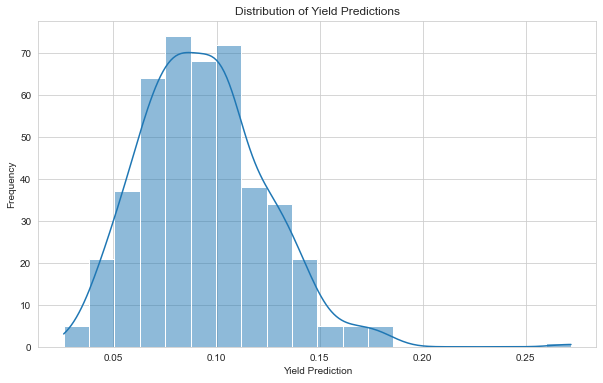

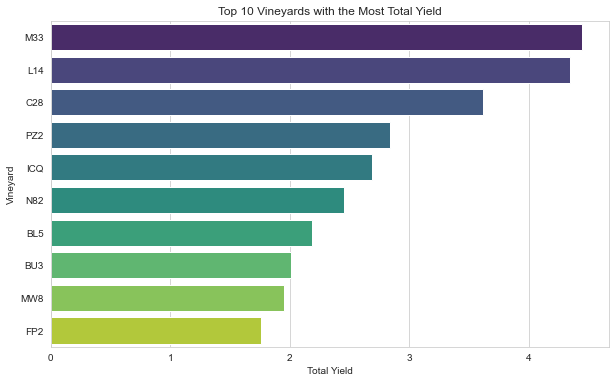

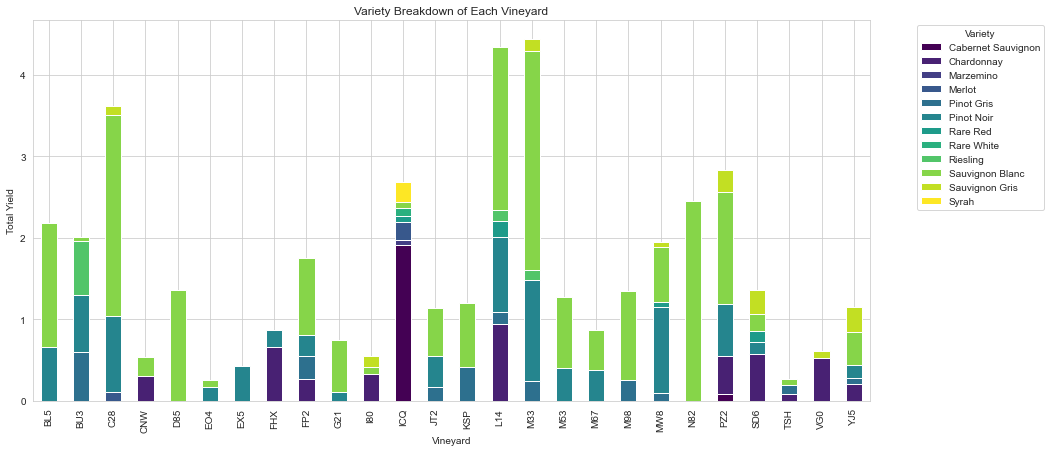

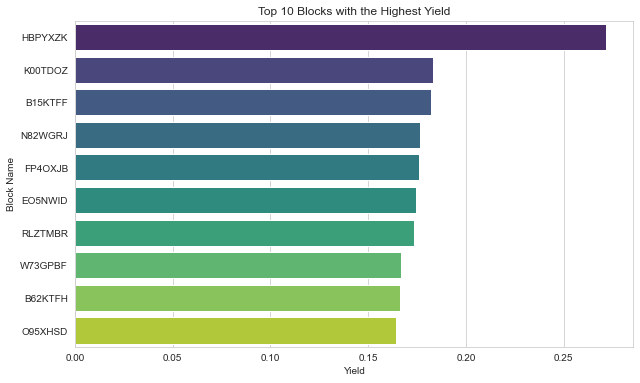

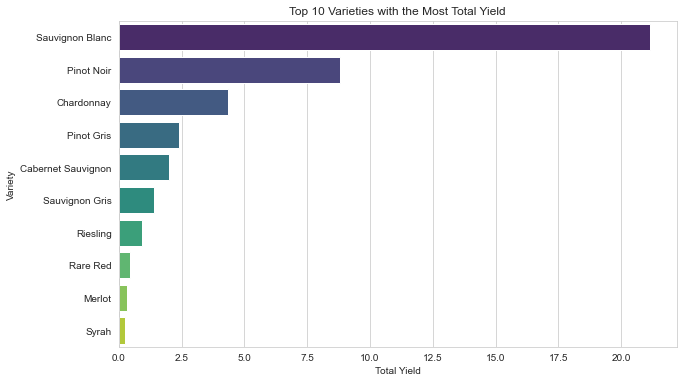

Variety  YieldPerHec_XGBPrediction
9      Sauvignon Blanc                  21.150705
5           Pinot Noir                   8.818318
1           Chardonnay                   4.350351
4           Pinot Gris                   2.401100
0   Cabernet Sauvignon                   2.003710
10      Sauvignon Gris                   1.413309
8             Riesling                   0.934392
6             Rare Red                   0.468331
3               Merlot                   0.330297
11               Syrah                   0.240901

In [50]:
# Importing necessary libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the plot styling
sns.set_style('whitegrid')

# Plotting the histogram for YieldPerHec_CBPrediction
plt.figure(figsize=(10, 6))
sns.histplot(yield_2022_data['YieldPerHec_XGBPrediction'], bins=20, kde=True)
plt.title('Distribution of Yield Predictions')
plt.xlabel('Yield Prediction')
plt.ylabel('Frequency')
plt.show()



# Calculating the total yield for each vineyard
vineyards_total_yield = yield_2022_data.groupby('Vineyard')['YieldPerHec_XGBPrediction'].sum().reset_index()

# Sorting by total yield to get the top 10 vineyards
top_10_vineyards_yield = vineyards_total_yield.nlargest(10, 'YieldPerHec_XGBPrediction')

# Plotting the top 10 vineyards with the most total yield
plt.figure(figsize=(10, 6))
sns.barplot(data=top_10_vineyards_yield, y='Vineyard', x='YieldPerHec_XGBPrediction', palette='viridis')
plt.title('Top 10 Vineyards with the Most Total Yield')
plt.xlabel('Total Yield')
plt.ylabel('Vineyard')
plt.show()

top_10_vineyards_yield


# Calculating the total yield for each variety within each vineyard
variety_breakdown = yield_2022_data.groupby(['Vineyard', 'Variety'])['YieldPerHec_XGBPrediction'].sum().reset_index()

# Pivoting the DataFrame to get varieties as columns for the stacked bar chart
variety_breakdown_pivot = variety_breakdown.pivot(index='Vineyard', columns='Variety', values='YieldPerHec_XGBPrediction').fillna(0)

# Plotting the stacked bar chart for variety breakdown within each vineyard
variety_breakdown_pivot.plot(kind='bar', stacked=True, figsize=(15, 7), cmap='viridis')
plt.title('Variety Breakdown of Each Vineyard')
plt.xlabel('Vineyard')
plt.ylabel('Total Yield')
plt.legend(title='Variety', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Finding the top 10 blocks with the highest yield
top_10_blocks_yield = yield_2022_data.nlargest(10, 'YieldPerHec_XGBPrediction')

# Plotting the top 10 blocks with the highest yield
plt.figure(figsize=(10, 6))
sns.barplot(data=top_10_blocks_yield, y='Block_name', x='YieldPerHec_XGBPrediction', palette='viridis')
plt.title('Top 10 Blocks with the Highest Yield')
plt.xlabel('Yield')
plt.ylabel('Block Name')
plt.show()

top_10_blocks_yield[['Block_name', 'YieldPerHec_XGBPrediction']]


# Calculating the total yield for each variety
varieties_total_yield = yield_2022_data.groupby('Variety')['YieldPerHec_XGBPrediction'].sum().reset_index()

# Sorting by total yield to get the top 10 varieties
top_10_varieties_yield = varieties_total_yield.nlargest(10, 'YieldPerHec_XGBPrediction')

# Plotting the top 10 varieties with the most total yield
plt.figure(figsize=(10, 6))
sns.barplot(data=top_10_varieties_yield, y='Variety', x='YieldPerHec_XGBPrediction', palette='viridis')
plt.title('Top 10 Varieties with the Most Total Yield')
plt.xlabel('Total Yield')
plt.ylabel('Variety')
plt.show()

top_10_varieties_yield


